# Recommend RBS sequences - Escherichia coli

This notebook shows the online recommendation of RBS sequences with the goal of achieving a high protein expression level.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - One-hot embedding
    - K-mer 
    - PMW
    - Kernels
    - Unsupervised 
- Create reward environment
- Apply bandits algorithms
    - GPUCB

## Some open questions

- How to define arms? In this notebook, we consider an RBS sequence is an arm, where arms are dependent (we assume similar sequences having similar protein expression levels). Are there any other ways to define arms? For example, how about define arms as different experts, where each expert recommends one arm.

- How to recommend multiple arms once?

- How to select embedding methods? How to evaluate them?

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import RBF

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/trainset.rbs1.v2.csv'

df = pandas.read_csv(Path, delimiter=',')
df.head()

,Construct,Barcode,rbs1_1_A,rbs1_1_C,rbs1_1_G,rbs1_1_T,rbs1_2_A,rbs1_2_C,rbs1_2_G,rbs1_2_T,...,rbs2_3_A,rbs2_3_C,rbs2_3_G,rbs2_3_T,Group,ODind,ODhar,FC,rbs1,rbs2
0,RBS629,77DD32,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.410,4.523,1.437982,GGG,GGG
1,RBS678,77DD39,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.359,2.678,1.277175,GGG,GGG
2,RBS353,77DD18,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.334,1.745,1.545141,GGC,GGG
3,RBS403,77DD20,0,0,1,0,0,0,1,0,...,1,0,0,0,Top,0.390,2.166,1.670098,GGC,GGA
4,RBS500,77DD24,0,0,1,0,0,0,1,0,...,0,1,0,0,Top,0.375,2.348,1.621230,GGC,GGC


In [8]:
df['RBS'] = df['rbs1'] + df['rbs2']
data = np.asarray(df[['RBS', 'FC']])
data.shape

(60, 2)

## Regression

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)
Train score:  0.768561032172
Test score:  0.741182694207


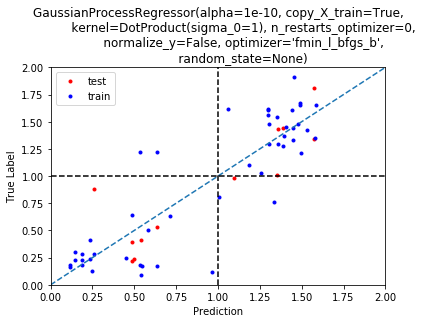

In [13]:
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'onehot')
reg.train()
reg.evaluate()

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)
Train score:  0.819315827136
Test score:  0.707412594398


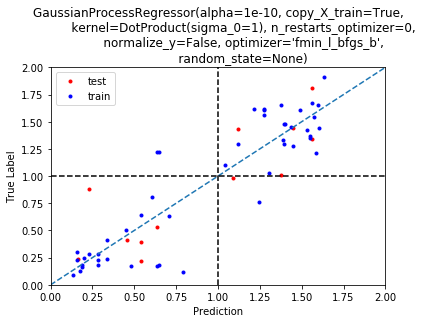

In [12]:
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'kmer')
reg.train()
reg.evaluate()

## Embedding & Create Rewards Environment

In [14]:
my_env = Rewards_env(data, 'onehot')

## Recommendations with GPUCB

In [15]:
num_rounds = 100
num_exper = 1
init_per = 0.2

sds = []
rs = []

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


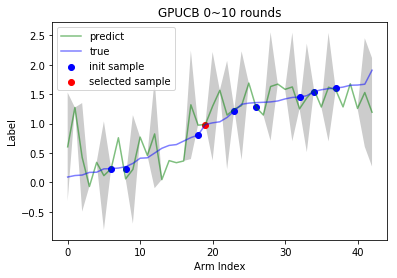

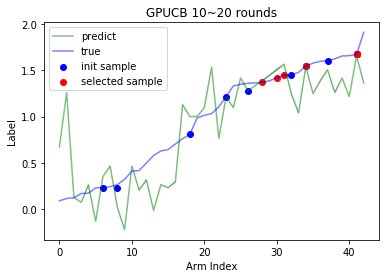

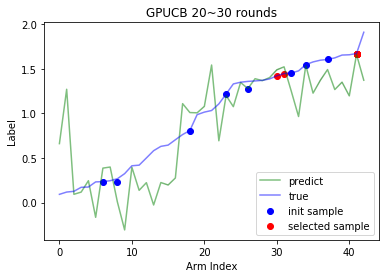

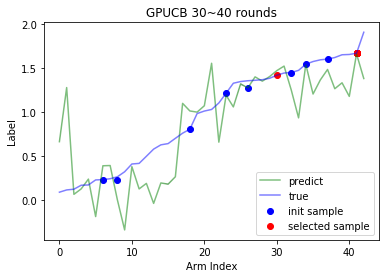

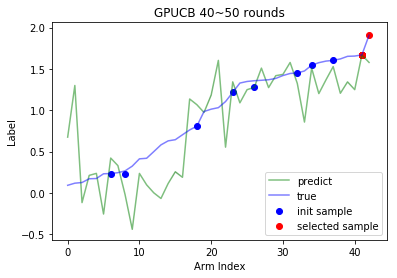

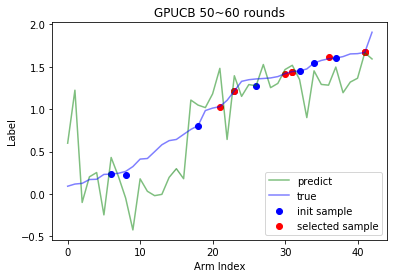

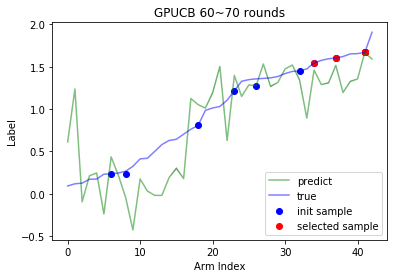

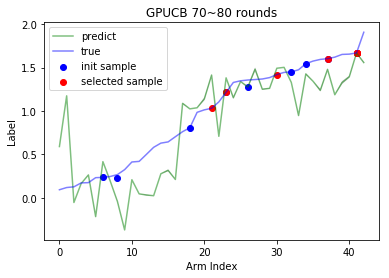

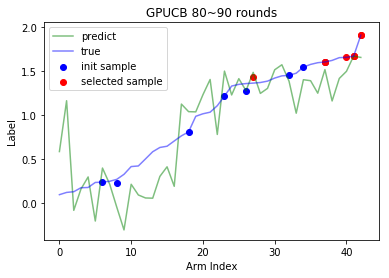

In [16]:
warnings.filterwarnings(action='ignore')

p = IntProgress(max = num_exper)
p.description = 'Running'
display(p)

for i in range(num_exper):
    p.value += 1
    agent = GPUCB(my_env, num_rounds, init_per)
    agent.play(plot_flag = True)
    sds.append(agent.suboptimalDraws)
    rs.append(agent.cumulativeRegrets)

In [17]:
results = evaluate(sds, rs)

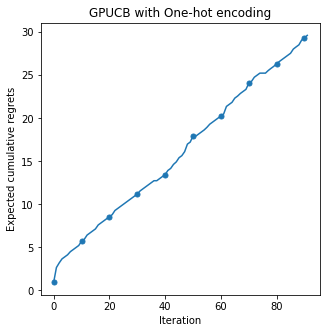

In [18]:
plot_eva(results, 'r')